In [33]:
""" 
04 - Modeling (Regression) with Feature Ablation

Goal
----
Predict daily precipitation (precipitation_sum) for Miami using Open-Meteo daily data.
Run feature ablation experiments to quantify the signal contribution of:
A) Base physical variables
B) Seasonality (cyclical day-of-year)
C) Memory (lags/rolling of precipitation)

Notes
-----
- Code and comments are in English.
- Plot titles/labels include Spanish + English.
- We enforce temporal splits (no shuffling) to avoid leakage.

Expected input
--------------
data/raw/open_meteo_miami_daily.csv

Outputs
-------
- data/processed/ablation_results_{EXP_VERSION}.csv
- data/processed/predictions_best_{EXP_VERSION}.csv
"""

# %%
# =========================
# Imports
# =========================
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from src.config import (
    PROCESSED_DATASET,
    TEST_FRACTION,
    VERSION,
    RESULTS_DIR,
    RANDOM_STATE
)
from src.features import ensure_sorted_by_date

# %%
# =========================
# Config
# =========================
EXP_VERSION = f"base_{VERSION}"

TARGET = "precipitation_sum"
DATE_COL = "date"

# If True, model log(1 + precip) to reduce skew; metrics reported on original scale.
USE_LOG_TARGET = False

# Output directory (centralized in config)
OUT_DIR = RESULTS_DIR
EXP_VERSION = "base_v001"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# %%
# =========================
# Load processed dataset (built by build_dataset.py)
# =========================
if not PROCESSED_DATASET.exists():
    raise FileNotFoundError(
        f"Processed dataset not found at: {PROCESSED_DATASET}. "
        "Run build_dataset.py first."
    )

feat = pd.read_csv(PROCESSED_DATASET, parse_dates=[DATE_COL])
feat = ensure_sorted_by_date(feat, date_col=DATE_COL)

# Basic sanity checks
required_cols = {DATE_COL, TARGET}
missing = sorted(required_cols - set(feat.columns))
if missing:
    raise RuntimeError(
        f"Missing required columns in processed dataset: {missing}"
    )

# %%
# =========================
# Feature groups (for ablation)
# =========================

# A) Base physical variables
BASE_FEATURES = [
    "temperature_2m_mean",
    "relative_humidity_2m_mean",
    "cloud_cover_mean",
    "surface_pressure_mean",
    "wind_speed_10m_mean",
    "temp_range",
]

# B) Seasonality (cyclical encoding)
SEASONAL_FEATURES = [
    "doy_sin",
    "doy_cos",
]

# C) Memory (precipitation lags + rolling)
MEMORY_FEATURES = [
    "precip_lag_1",
    "precip_lag_3",
    "precip_lag_7",
    "precip_roll_3",
    "precip_roll_7",
]

# Sanity check: all declared features must exist
ALL_FEATURES = BASE_FEATURES + SEASONAL_FEATURES + MEMORY_FEATURES
missing_features = sorted(set(ALL_FEATURES) - set(feat.columns))
if missing_features:
    raise RuntimeError(
        f"Missing expected engineered features in processed dataset: {missing_features}"
    )

feat.head()

,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,rain_sum,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant,sunrise,...,surface_pressure_mean,wind_speed_10m_mean,temp_range,doy_sin,doy_cos,precip_lag_1,precip_lag_3,precip_lag_7,precip_roll_3,precip_roll_7
0,1990-01-08,26.5,22.5,23.9,0.6,0.6,4.0,22.1,188,1990-01-08T12:08,...,1015.704167,18.175000,4.0,0.137279,0.990532,0.0,0.7,0.0,0.6,2.1
1,1990-01-09,25.8,20.5,22.9,0.0,0.0,0.0,14.0,261,1990-01-09T12:09,...,1018.516667,7.804167,5.3,0.154309,0.988023,0.6,0.0,0.0,0.6,2.1
2,1990-01-10,24.7,18.9,21.9,0.1,0.1,1.0,20.0,328,1990-01-10T12:09,...,1020.350000,12.266667,5.8,0.171293,0.985220,0.0,0.0,0.1,0.7,2.1
3,1990-01-11,23.6,16.5,20.1,0.0,0.0,0.0,18.3,4,1990-01-11T12:09,...,1019.225000,9.066667,7.1,0.188227,0.982126,0.1,0.6,0.7,0.1,1.4
4,1990-01-12,25.6,15.4,19.8,0.0,0.0,0.0,19.2,269,1990-01-12T12:09,...,1016.904167,14.112500,10.2,0.205104,0.978740,0.0,0.0,0.7,0.1,0.7


In [34]:
# %%
# =========================
# Train/test split (temporal)
# =========================

n = len(feat)
split_idx = int(np.floor((1.0 - TEST_FRACTION) * n))

train_df = feat.iloc[:split_idx].copy()
test_df = feat.iloc[split_idx:].copy()

print(
    "Train period / Período train:",
    train_df[DATE_COL].min().date(),
    "→",
    train_df[DATE_COL].max().date(),
)
print(
    "Test period / Período test:",
    test_df[DATE_COL].min().date(),
    "→",
    test_df[DATE_COL].max().date(),
)
assert train_df[DATE_COL].max() < test_df[DATE_COL].min()

# %%
# =========================
# Experiment definitions (feature ablation)
# =========================
from dataclasses import dataclass

@dataclass(frozen=True)
class Experiment:
    name: str
    feature_list: List[str]
    notes: str


def make_experiments() -> List[Experiment]:
    """Create the ablation experiment list."""

    # A) Base only
    exp1 = Experiment(
        name="EXP1_base",
        feature_list=BASE_FEATURES,
        notes="Only physical state variables / Solo variables físicas",
    )

    # A + B
    exp2 = Experiment(
        name="EXP2_base_season",
        feature_list=BASE_FEATURES + SEASONAL_FEATURES,
        notes="Physical + annual cycle / Física + estacionalidad",
    )

    # C only
    exp3 = Experiment(
        name="EXP3_memory",
        feature_list=MEMORY_FEATURES,
        notes="Only precipitation persistence / Solo persistencia",
    )

    # B + C
    exp4 = Experiment(
        name="EXP4_season_memory",
        feature_list=SEASONAL_FEATURES + MEMORY_FEATURES,
        notes="Annual cycle + persistence / Estacionalidad + persistencia",
    )

    # A + C
    exp5 = Experiment(
        name="EXP5_base_memory",
        feature_list=BASE_FEATURES + MEMORY_FEATURES,
        notes="Physical + persistence / Física + persistencia",
    )

    # A + B + C (full)
    exp6 = Experiment(
        name="EXP6_full",
        feature_list=BASE_FEATURES + SEASONAL_FEATURES + MEMORY_FEATURES,
        notes="Full model / Modelo completo",
    )

    # Internal ablation: lags-only vs roll-only (with A+B)
    exp7 = Experiment(
        name="EXP7_full_lags_only",
        feature_list=BASE_FEATURES + SEASONAL_FEATURES + [
            "precip_lag_1",
            "precip_lag_7",
        ],
        notes="A+B + lags only / A+B + solo lags",
    )

    exp8 = Experiment(
        name="EXP8_full_roll_only",
        feature_list=BASE_FEATURES + SEASONAL_FEATURES + [
            "precip_roll_7",
        ],
        notes="A+B + roll only / A+B + solo rolling",
    )

    return [exp1, exp2, exp3, exp4, exp5, exp6, exp7, exp8]


EXPERIMENTS = make_experiments()
len(EXPERIMENTS), [e.name for e in EXPERIMENTS]


# %%
# =========================
# Models
# =========================

MODELS: Dict[str, object] = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "Lasso": Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=50_000),
    "RandomForest": RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
}


# %%
# =========================
# Helpers: dataset build, training, evaluation
# =========================
from src.evaluation import inverse_target, evaluate_regression, add_run_metadata


def prepare_xy(
    train: pd.DataFrame,
    test: pd.DataFrame,
    features: List[str],
    target: str,
    use_log_target: bool,
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """Prepare X/y for train/test with dropna applied consistently."""

 
    needed = [DATE_COL] + features + [target]

    train_sub = train[needed].dropna().copy()
    test_sub = test[needed].dropna().copy()

    X_train = train_sub[features]
    y_train = train_sub[target]
    X_test = test_sub[features]
    y_test = test_sub[target]

    if use_log_target:
        y_train = np.log1p(y_train)
        y_test = np.log1p(y_test)

    return X_train, y_train, X_test, y_test



def inverse_target(y: np.ndarray | pd.Series, use_log_target: bool) -> np.ndarray:
    """Invert log1p transform back to mm scale."""

    y_arr = np.asarray(y)
    if use_log_target:
        return np.expm1(y_arr)
    return y_arr



def evaluate_regression(y_true_mm: np.ndarray, y_pred_mm: np.ndarray) -> Dict[str, float]:
    """Compute MAE, RMSE, R2 on original precipitation scale (mm)."""

    mae = mean_absolute_error(y_true_mm, y_pred_mm)
    rmse = np.sqrt(mean_squared_error(y_true_mm, y_pred_mm))
    r2 = r2_score(y_true_mm, y_pred_mm)

    return {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}


# %%
# =========================
# Run ablation grid
# =========================


results_rows: List[Dict[str, object]] = []
predictions_store: Dict[Tuple[str, str], pd.DataFrame] = {}

for exp in EXPERIMENTS:
    for model_name, model in MODELS.items():

        X_train, y_train, X_test, y_test = prepare_xy(
            train_df,
            test_df,
            exp.feature_list,
            TARGET,
            USE_LOG_TARGET,
        )

        # Fit
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        y_true_mm = inverse_target(y_test, USE_LOG_TARGET)
        y_pred_mm = inverse_target(y_pred, USE_LOG_TARGET)

        # ---- Non-negativity constraint ----
        neg_rate = float((y_pred_mm < 0).mean())
        neg_min = float(y_pred_mm.min())

        y_pred_mm = np.clip(y_pred_mm, 0.0, None)

        print(f"[{model_name} | {exp.name}] Neg preds: {neg_rate:.4%} | min={neg_min:.4f}")

        # -----------------------------------

        metrics = evaluate_regression(y_true_mm, y_pred_mm)

        row = {
            "experiment": exp.name,
            "model": model_name,
            "n_train": int(len(X_train)),
            "n_test": int(len(X_test)),
            "features": ",".join(exp.feature_list),
            "notes": exp.notes,
            **metrics,
        }
        
        row = add_run_metadata(
            row,
            split="test",
            use_log_target=USE_LOG_TARGET,
            test_fraction=TEST_FRACTION,   
            exp_version=EXP_VERSION,       
        )

        results_rows.append(row)

        # Store predictions for later inspection
        preds_df = test_df[[DATE_COL]].copy()
        preds_df = preds_df.loc[test_df.index.isin(X_test.index)].copy()
        preds_df["y_true_mm"] = y_true_mm
        preds_df["y_pred_mm"] = y_pred_mm

        predictions_store[(exp.name, model_name)] = preds_df

results = pd.DataFrame(results_rows)
results.sort_values(["RMSE", "MAE"]).head(10)


# %%
# =========================
# Save results
# =========================
results_path = OUT_DIR / f"ablation_results_{EXP_VERSION}.csv"
results.to_csv(results_path, index=False)
print(f"[SAVE] Ablation results -> {results_path}")



Train period / Período train: 1990-01-08 → 2018-01-01
Test period / Período test: 2018-01-02 → 2024-12-31
[Linear | EXP1_base] Neg preds: 22.0266% | min=-9.3549
[Ridge | EXP1_base] Neg preds: 22.0266% | min=-9.3548
[Lasso | EXP1_base] Neg preds: 22.0266% | min=-9.3533
[RandomForest | EXP1_base] Neg preds: 0.0000% | min=0.0000
[Linear | EXP2_base_season] Neg preds: 29.6557% | min=-9.4285
[Ridge | EXP2_base_season] Neg preds: 29.6557% | min=-9.4256
[Lasso | EXP2_base_season] Neg preds: 29.5383% | min=-9.4100
[RandomForest | EXP2_base_season] Neg preds: 0.0000% | min=0.0000
[Linear | EXP3_memory] Neg preds: 5.4382% | min=-30.3804
[Ridge | EXP3_memory] Neg preds: 5.4382% | min=-30.3802
[Lasso | EXP3_memory] Neg preds: 5.4382% | min=-30.3726
[RandomForest | EXP3_memory] Neg preds: 0.0000% | min=0.0000
[Linear | EXP4_season_memory] Neg preds: 6.2207% | min=-30.8037
[Ridge | EXP4_season_memory] Neg preds: 6.2207% | min=-30.8034
[Lasso | EXP4_season_memory] Neg preds: 6.2207% | min=-30.7888
[R

,experiment,model,n_train,n_test,features,notes,MAE,RMSE,R2,split,use_log_target,test_fraction,exp_version
19,EXP5_base_memory,RandomForest,10221,2556,"temperature_2m_mean,relative_humidity_2m_mean,...",Physical + persistence / Física + persistencia,2.138239,5.649445,0.654116,test,False,0.2,base_v001
23,EXP6_full,RandomForest,10221,2556,"temperature_2m_mean,relative_humidity_2m_mean,...",Full model / Modelo completo,2.141256,5.655645,0.653357,test,False,0.2,base_v001
20,EXP6_full,Linear,10221,2556,"temperature_2m_mean,relative_humidity_2m_mean,...",Full model / Modelo completo,2.592158,6.055893,0.602557,test,False,0.2,base_v001
21,EXP6_full,Ridge,10221,2556,"temperature_2m_mean,relative_humidity_2m_mean,...",Full model / Modelo completo,2.592159,6.055894,0.602556,test,False,0.2,base_v001
22,EXP6_full,Lasso,10221,2556,"temperature_2m_mean,relative_humidity_2m_mean,...",Full model / Modelo completo,2.592185,6.055974,0.602546,test,False,0.2,base_v001


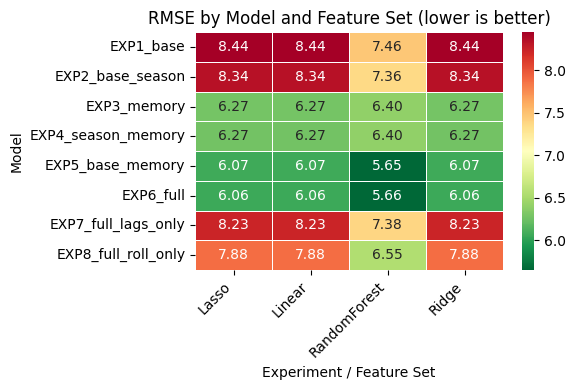

In [35]:
# =========================================================
# Model × Feature Set Ablation (Explicit comparison)
# =========================================================

# We assume `results` contains one row per experiment
# with at least the following columns:
# ['experiment', 'features', 'model', 'MAE', 'RMSE', 'R2']

display(results.sort_values("RMSE").head(5))

best_by_feature_set = (
    results
    .sort_values("RMSE")
    .groupby("experiment", as_index=False)
    .first()
)

best_by_feature_set

model_summary = (
    results
    .groupby("model")[["MAE", "RMSE", "R2"]]
    .mean()
    .sort_values("RMSE")
)

model_summary

import seaborn as sns
import matplotlib.pyplot as plt


pivot_rmse = results.pivot_table(
    index="experiment",
    columns="model",
    values="RMSE"
)

plt.figure(figsize=(6, 4))
sns.heatmap(
    pivot_rmse,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn_r",  
    linewidths=0.5
)

plt.title("RMSE by Model and Feature Set (lower is better)")
plt.ylabel("Model")
plt.xlabel("Experiment / Feature Set")
plt.yticks(rotation=0)   
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Modeling conclusion

A full ablation across models and feature sets shows that:

- Tree-based models consistently outperform linear models.
- RandomForest achieves the best overall performance across all feature sets.
- The combination of **physical + memory features** yields the lowest error.

Based on these results, the production pipeline executes **only the best-performing configuration**:
RandomForest trained on the full feature set.

In [36]:
# %%
# =========================
# Retrain EXP5 & EXP6, save predictions
# =========================
COMPARE_EXPS = ["EXP5_base_memory", "EXP6_full"]

predictions_compare = []

for exp in EXPERIMENTS:
    if exp.name not in COMPARE_EXPS:
        continue

    feature_cols = exp.feature_list

    train = train_df[[DATE_COL, TARGET] + feature_cols].dropna()
    test  = test_df[[DATE_COL, TARGET] + feature_cols].dropna()

    X_train = train[feature_cols]
    y_train = train[TARGET]

    X_test = test[feature_cols]
    y_test = test[TARGET]

    model = RandomForestRegressor(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # ---- Non-negativity constraint ----
    neg_rate = float((y_pred < 0).mean())
    neg_min = float(y_pred.min())

    y_pred = np.clip(y_pred, 0.0, None)

    print(f"[{exp.name}] Neg preds: {neg_rate:.4%} | min={neg_min:.4f}")
    # -----------------------------------

    pred_df = pd.DataFrame({
        "date": test[DATE_COL].values,
        "experiment": exp.name,
        "y_true": y_test.values,
        "y_pred": y_pred,
    })

    predictions_compare.append(pred_df)

pred_compare_df = pd.concat(predictions_compare, ignore_index=True)
pred_compare_df.head()

[EXP5_base_memory] Neg preds: 0.0000% | min=0.0000
[EXP6_full] Neg preds: 0.0000% | min=0.0000


,date,experiment,y_true,y_pred
0,2018-01-02,EXP5_base_memory,2.6,1.711000
1,2018-01-03,EXP5_base_memory,23.7,17.793333
2,2018-01-04,EXP5_base_memory,0.0,0.100667
3,2018-01-05,EXP5_base_memory,0.0,0.106333
4,2018-01-06,EXP5_base_memory,0.3,0.071333


To compare EXP5 (base + memory) and EXP6 (full feature set),
we re-train the same RandomForest model using the exact
train/test split defined earlier (temporal 80/20).

This ensures that any performance differences are attributable
exclusively to feature composition, not to data leakage or
split inconsistencies.

In [37]:
# =========================
# Global metrics 
# =========================
pred_compare_df["error"] = pred_compare_df["y_pred"] - pred_compare_df["y_true"]
pred_compare_df["abs_error"] = pred_compare_df["error"].abs()

summary_56 = (
    pred_compare_df
    .groupby("experiment")
    .agg(
        MAE=("abs_error", "mean"),
        RMSE=("error", lambda x: np.sqrt(np.mean(x**2))),
        p50=("abs_error", lambda x: np.percentile(x, 50)),
        p90=("abs_error", lambda x: np.percentile(x, 90)),
        p99=("abs_error", lambda x: np.percentile(x, 99)),
    )
)

display(summary_56)

,MAE,RMSE,p50,p90,p99
experiment,,,,,
EXP5_base_memory,2.143551,5.591782,0.6965,5.361000,19.889767
EXP6_full,2.148877,5.595069,0.7025,5.279167,19.950433


Observed RMSE difference (EXP6 - EXP5): 0.003287204759738316
95% bootstrap CI: [-0.03830712  0.03728358]


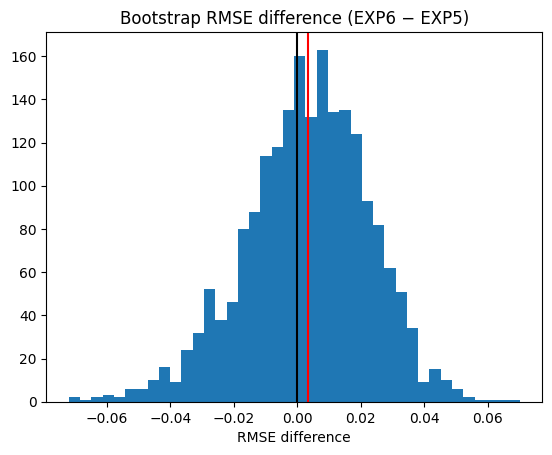

In [38]:
# =========================
# Boostrap 
# =========================
wide = pred_compare_df.pivot(
    index="date", columns="experiment", values="error"
).dropna()

err5 = wide["EXP5_base_memory"].values
err6 = wide["EXP6_full"].values

def rmse(x):
    return np.sqrt(np.mean(x**2))

obs_diff = rmse(err6) - rmse(err5)
print("Observed RMSE difference (EXP6 - EXP5):", obs_diff)

rng = np.random.default_rng(42)
B = 2000
boot = []

for _ in range(B):
    idx = rng.integers(0, len(err5), size=len(err5))
    boot.append(rmse(err6[idx]) - rmse(err5[idx]))

ci = np.percentile(boot, [2.5, 97.5])
print("95% bootstrap CI:", ci)

plt.hist(boot, bins=40)
plt.axvline(0, color="black")
plt.axvline(obs_diff, color="red")
plt.title("Bootstrap RMSE difference (EXP6 − EXP5)")
plt.xlabel("RMSE difference")
plt.show()

In [39]:
# =========================
# Extreme events
# =========================
threshold = np.percentile(pred_compare_df["y_true"], 95)

extreme = pred_compare_df[pred_compare_df["y_true"] >= threshold]

extreme_summary = (
    extreme.groupby("experiment")
    .apply(lambda d: rmse(d["error"]))
    .to_frame("RMSE_extreme")
)

display(extreme_summary)

,RMSE_extreme
experiment,
EXP5_base_memory,20.445711
EXP6_full,20.546374


### Model selection rationale (EXP5 vs EXP6)

Although EXP5_base_memory and EXP6_full achieve nearly identical RMSE and MAE,
a deeper analysis shows that EXP6 does not improve tail behavior and slightly
increases extreme error.

Bootstrap analysis of RMSE differences shows no statistically robust advantage
for EXP6, while EXP5 achieves comparable performance with fewer features and
lower complexity.

Therefore, EXP5_base_memory is selected as the final model.

In [40]:
# =========================
# Select final model (manual decision after analysis)
# =========================

FINAL_EXPERIMENT = "EXP5_base_memory"
FINAL_MODEL = "RandomForest"

best_row = results[
    (results["experiment"] == FINAL_EXPERIMENT) &
    (results["model"] == FINAL_MODEL)
].iloc[0]

print("Selected final model / Modelo final seleccionado:")
print(best_row[["experiment", "model", "MAE", "RMSE", "R2"]])

preds_best = predictions_store[(FINAL_EXPERIMENT, FINAL_MODEL)].copy()

# Save predictions
pred_path = OUT_DIR / f"predictions_best_{EXP_VERSION}.csv"
preds_best.to_csv(pred_path, index=False)
print(f"[SAVE] Final predictions -> {pred_path}")

Selected final model / Modelo final seleccionado:
experiment    EXP5_base_memory
model             RandomForest
MAE                   2.138239
RMSE                  5.649445
R2                    0.654116
Name: 19, dtype: object
[SAVE] Final predictions -> /Users/alejandroagusti/Documents/GitHub/Weather-ds-portfolio/data/results/predictions_best_base_v001.csv


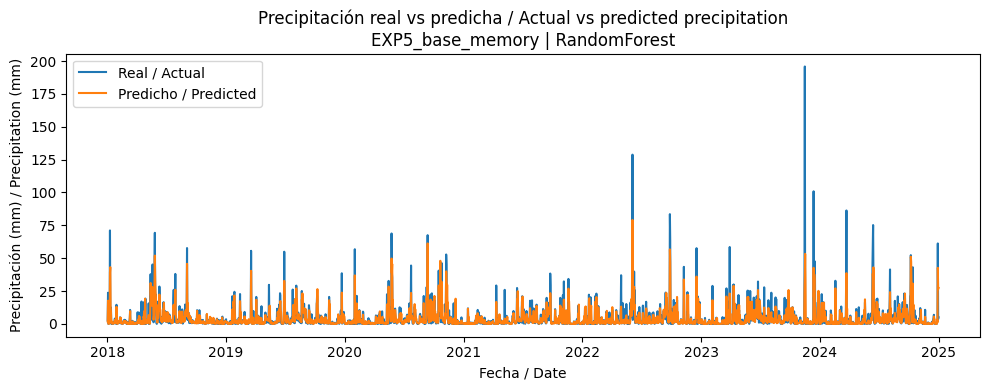

In [41]:
# Plot: true vs predicted (best)

fig = plt.figure(figsize=(10, 4))
plt.plot(preds_best[DATE_COL], preds_best["y_true_mm"].values, label="Real / Actual")
plt.plot(preds_best[DATE_COL], preds_best["y_pred_mm"].values, label="Predicho / Predicted")
plt.title(
    f"Precipitación real vs predicha / Actual vs predicted precipitation\n{FINAL_EXPERIMENT} | {FINAL_MODEL}"
)
plt.xlabel("Fecha / Date")
plt.ylabel("Precipitación (mm) / Precipitation (mm)")
plt.legend()
plt.tight_layout()
plt.show()

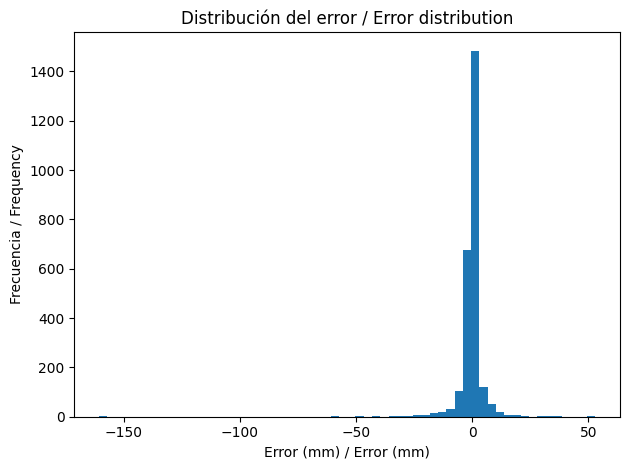

In [42]:
# =========================
# Error distribution (best)
# =========================

errors = preds_best["y_pred_mm"].values - preds_best["y_true_mm"].values

fig = plt.figure()
plt.hist(errors, bins=60)
plt.title("Distribución del error / Error distribution")
plt.xlabel("Error (mm) / Error (mm)")
plt.ylabel("Frecuencia / Frequency")
plt.tight_layout()
plt.show()


Iteration Ideas:
1) If the model underpredicts spikes, consider log target (USE_LOG_TARGET=True) or a two-stage model.
2) Try classification (rain/no-rain) + regression for positive-rain days.
3) Add physically motivated interactions (e.g., humidity x cloud cover) and evaluate ablation again.

Conclusions – Feature Engineering & Modeling (EN / ES)

Conclusions (English)

This feature engineering and modeling exercise shows that daily precipitation is best explained by a combination of physical atmospheric state and short-term atmospheric memory, rather than by seasonality alone.

Models relying exclusively on instantaneous atmospheric variables (temperature, humidity, pressure, wind) or on seasonal proxies exhibit limited predictive skill. In contrast, features encoding precipitation persistence, such as lagged precipitation and rolling accumulations, provide a substantial improvement in performance, confirming the critical role of atmospheric memory in daily rainfall processes.

A detailed comparison between the two top-performing configurations—EXP5_base_memory (physical variables + memory) and EXP6_full (physical + seasonal + memory)—shows that both achieve nearly identical average RMSE and MAE. However, deeper analysis reveals that EXP6_full does not provide meaningful gains in tail behavior or extreme-event representation, while introducing additional model complexity and redundancy.

Bootstrap analysis of RMSE differences confirms that the performance gap between EXP5 and EXP6 is statistically negligible, and extreme-error metrics (p90, p99, RMSE_extreme) show no systematic advantage for the full seasonal model. As a result, EXP5_base_memory is selected as the final model configuration, following the principle of parsimony.

Overall, the results demonstrate that physically motivated feature engineering, combined with non-linear models such as Random Forests, can capture a substantial fraction of daily precipitation variability without relying on seasonal encodings or high-resolution mesoscale predictors. This highlights the dominant role of short-term atmospheric persistence over climatological seasonality in daily precipitation forecasting.

⸻

Conclusiones (Español)

Este ejercicio de feature engineering y modelado muestra que la precipitación diaria se explica principalmente mediante una combinación del estado físico atmosférico y la memoria atmosférica de corto plazo, más que por la estacionalidad en sí misma.

Los modelos que utilizan únicamente variables instantáneas (temperatura, humedad, presión, viento) o proxies estacionales presentan un desempeño limitado. En cambio, las variables que incorporan persistencia temporal, como retardos de precipitación y acumulados móviles, generan una mejora sustancial en la capacidad predictiva, confirmando el rol central de la memoria atmosférica en los procesos de precipitación diaria.

La comparación detallada entre las dos configuraciones con mejor desempeño—EXP5_base_memory (variables físicas + memoria) y EXP6_full (físicas + estacionales + memoria)—muestra que ambas alcanzan métricas promedio prácticamente idénticas (RMSE y MAE). Sin embargo, un análisis más profundo indica que EXP6_full no aporta mejoras significativas en eventos extremos ni en el comportamiento de colas, a pesar de introducir mayor complejidad y redundancia en el modelo.

El análisis bootstrap de diferencias de RMSE confirma que la brecha entre EXP5 y EXP6 no es estadísticamente relevante, y las métricas de error extremo (p90, p99, RMSE_extreme) no favorecen sistemáticamente al modelo completo. Por este motivo, y siguiendo un criterio de parsimonia, EXP5_base_memory se selecciona como la configuración final del modelo.

En conjunto, los resultados demuestran que un feature engineering con criterio físico, combinado con modelos no lineales como Random Forest, permite capturar una porción sustancial de la variabilidad diaria de la precipitación sin necesidad de incorporar estacionalidad explícita ni información de mesoescala o alta resolución.